<a href="https://colab.research.google.com/github/sofymunari/JiGenProject/blob/main/Copia_di_Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [1]:
!pip3 install 'torch==1.4.0'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 753.4MB 24kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 4.0MB 23.7MB/s 
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 634kB 32.1MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp37-cp37m-linux_x86_64.whl size=1206231 sha256=659ebeafb0b67dab597086c266aaab16d299a88ecfd14266c11cfe3ae1d5790e
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


**Import libraries**

In [ ]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean 

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18, resnet50

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101    # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05      # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 5

PRE_TRAINED = False     # set to True to load the pre-trained AlexNet

FREEZING = None        # define which layers of the network will be kept frozen
                       # None : train the whole network
                       # "CONV" : train only the FC-layers
                       # "FC" : train only the conv-layers

AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch
AUG_TYPE = None      # define the type of augmentation pipeline 
                     # None for no data augmentation
                     # "CS-HF" for contrast + saturation + horizontal flip
                     # "H-RP" for hue + random perspective
                     # "B-GS-R" for brightness + grayscale + rotation

**Define Data Preprocessing**

In [ ]:
                                 
if PRE_TRAINED:
  normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
else:
  normalizer = transforms.Normalize(mean = (0.5, 0.5, 0.5), std=(0.229, 0.224, 0.225))

# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor()
])


# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224), 
                                     transforms.ToTensor()                               
])

bright_t = transforms.ColorJitter(brightness=[1,2])
contrast_t = transforms.ColorJitter(contrast = [2,5])
saturation_t = transforms.ColorJitter(saturation = [1,3])
hue_t = transforms.ColorJitter(hue = 0.2)
gs_t = transforms.Grayscale(3)
hflip_t = transforms.RandomHorizontalFlip(p = 1)
rp_t = transforms.RandomPerspective(p = 1, distortion_scale = 0.5)
rot_t = transforms.RandomRotation(degrees = 90)

aug_transformations = {
    "CS-HF": transforms.Compose([contrast_t, saturation_t, hflip_t]),
    "H-RP": transforms.Compose([hue_t, rp_t]),
    "B-GS-R": transforms.Compose([bright_t, gs_t, rot_t])
    }

if AUG_TYPE is not None:
  aug_transformation = aug_transformations[AUG_TYPE]
  aug_pipeline = transforms.Compose([ 
                                      transforms.ToPILImage(),
                                      transforms.RandomApply([aug_transformation], p = AUG_PROB),
                                      transforms.ToTensor(),
                                      normalizer
                                     ])
else:
  aug_pipeline = normalizer

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./MLA'):
  !git clone https://github.com/sofymunari/MLA.git
  

DATA_DIR = 'MLA/101_ObjectCategories'
from MLA.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset_big = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)



train_dataset_big.__makesplit__()
train_indexes = train_dataset_big.__trainsplit__() # split the indices for your train split
val_indexes = train_dataset_big.__validsplit__() # split the indices for your val split

train_dataset = Subset(train_dataset_big, train_indexes)
val_dataset = Subset(train_dataset_big, val_indexes)
print(val_dataset.__getitem__(1284))

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6078, 0.6078, 0.6118],
         [0.0000, 0.0000, 0.0000,  ..., 0.6039, 0.6078, 0.6078],
         [0.0000, 0.0000, 0.0000,  ..., 0.5843, 0.5882, 0.5882],
         ...,
         [0.2706, 0.2000, 0.3137,  ..., 0.0000, 0.0000, 0.0000],
         [0.3216, 0.2275, 0.2667,  ..., 0.0000, 0.0000, 0.0000],
         [0.3098, 0.2706, 0.2588,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7961, 0.7882, 0.7882],
         [0.0000, 0.0000, 0.0000,  ..., 0.7922, 0.7882, 0.7843],
         [0.0000, 0.0000, 0.0000,  ..., 0.7725, 0.7686, 0.7647],
         ...,
         [0.1686, 0.0980, 0.2118,  ..., 0.0000, 0.0000, 0.0000],
         [0.2549, 0.1686, 0.2078,  ..., 0.0000, 0.0000, 0.0000],
         [0.2471, 0.2157, 0.2039,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.8824, 0.8784, 0.8784],
         [0.0000, 0.0000, 0.0000,  ..., 0.8784, 0.8784, 0.8745],
         [0.0000, 0.0000, 0.0000,  ..., 0.8588, 0.8588, 0

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model

#AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code
#net = resnet50(pretrained=PRE_TRAINED)
#net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES)

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# e.g.: parameters of the whole network: net.parameters()
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: net.features.parameters() or net.fc.parameters()
if FREEZING is not None:
  if FREEZING == "FC":
    parameters_to_optimize = net.features.parameters() 
  else:
    # parameters_to_optimize = net.classifier.parameters()
    parameters_to_optimize = net.fc.parameters()
else:
  parameters_to_optimize = net.parameters()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Validation**

In [ ]:
def evaluate(net, dataloader, print_tqdm = True):
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizer(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

  return accuracy, mean(losses)

**train and validation**

In [ ]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    aug_images = []

    for image in images:
      aug_image = aug_pipeline(image) 
      aug_images.append(aug_image) 

    aug_images = torch.stack(aug_images)

    # Bring data over the device of choice
    aug_images = aug_images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(aug_images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))
    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  train_acc, train_loss = evaluate(net, train_dataloader, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss = evaluate(net, val_dataloader, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  # Step the scheduler
  scheduler.step()

Starting epoch 1/30, LR = [0.05]
Step 0, Loss 4.61537504196167
Step 5, Loss 4.594698905944824
Step 10, Loss 4.26484489440918
Step 15, Loss 4.570113182067871
Step 20, Loss 4.51682186126709
Step 25, Loss 4.549336910247803
Starting epoch 2/30, LR = [0.05]
Step 30, Loss 4.486270427703857
Step 35, Loss 4.452315807342529
Step 40, Loss 4.325311660766602
Step 45, Loss 4.278230667114258
Step 50, Loss 4.375396728515625
Step 55, Loss 4.2914652824401855
Starting epoch 3/30, LR = [0.05]
Step 60, Loss 4.309173583984375
Step 65, Loss 4.120245456695557
Step 70, Loss 4.230928421020508
Step 75, Loss 4.265066146850586
Step 80, Loss 4.352932453155518
Step 85, Loss 4.247264862060547
Starting epoch 4/30, LR = [0.05]
Step 90, Loss 4.201113700866699
Step 95, Loss 4.256072998046875
Step 100, Loss 4.1246514320373535
Step 105, Loss 4.162686824798584
Step 110, Loss 4.178223133087158
Step 115, Loss 4.221297740936279
Starting epoch 5/30, LR = [0.05]
Step 120, Loss 4.162060737609863
Step 125, Loss 4.207042217254639


**Test**

  0%|          | 0/23 [00:00<?, ?it/s]

Best accuracies on the validation set:  0.4600622406639004


100%|██████████| 23/23 [00:09<00:00,  2.37it/s]



Test Accuracy: 0.4593847217421362


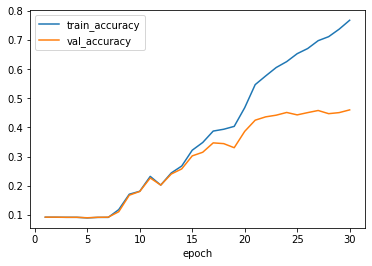

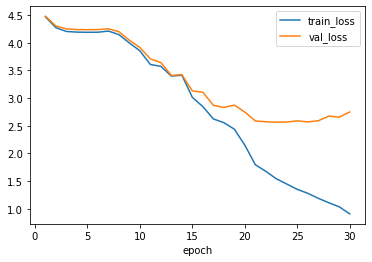

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])


#test
accuracy = evaluate(net, test_dataloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))